In [119]:
import numpy as np
from numpy.fft import fftshift, fftfreq, fft
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append("..")
from utils import *

In [87]:
df = pd.read_csv("../simulation/data/debug/excitation_sinusoidal.csv")

In [88]:
df

,Unnamed: 0,t,x,y,fx,fy,freq,axis,seal,episode
0,0,0.0000,0.000000e+00,0.000000e+00,0.000000,0.000000,4,x,True,0
1,1,0.0001,4.182320e-12,-8.983704e-19,0.002513,0.000000,4,x,True,0
2,2,0.0002,3.339201e-11,-7.739025e-16,0.005027,0.000000,4,x,True,0
3,3,0.0003,1.125290e-10,-2.350727e-15,0.007540,0.000000,4,x,True,0
4,4,0.0004,2.663489e-10,-4.205185e-15,0.010053,0.000000,4,x,True,0
...,...,...,...,...,...,...,...,...,...,...
5599995,99995,9.9995,0.000000e+00,8.610058e-07,-0.000000,-0.215076,69,y,False,0
5599996,99996,9.9996,0.000000e+00,6.239603e-07,-0.000000,-0.172548,69,y,False,0
5599997,99997,9.9997,0.000000e+00,3.857281e-07,-0.000000,-0.129696,69,y,False,0
5599998,99998,9.9998,0.000000e+00,1.468552e-07,-0.000000,-0.086599,69,y,False,0


In [116]:
freq = 69
sel_df = df[(df.seal == False) & (df.axis == "x") & (df.episode == 0) & (df.freq == freq)]

(2.0, 3.0)

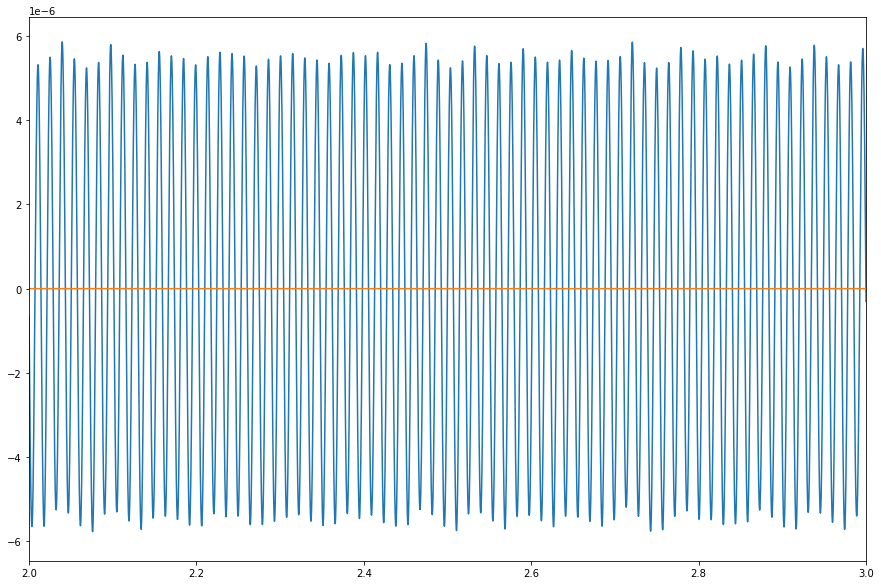

In [117]:
plt.figure(figsize=(15,10))
plt.plot(sel_df.t[sel_df.t > 2], sel_df.x[sel_df.t > 2])
plt.plot(sel_df.t[sel_df.t > 2], sel_df.y[sel_df.t > 2])
plt.xlim(2, 3)

# Linear Regression

In [102]:
def linreg_estimate(df):
    
    #df["x_dot2"] =  df["x_dot2"].shift()
    #df["y_dot2"] =  df["y_dot2"].shift()
    
    df = df[df.t > 0.5]
    X = df[["x_dot", "y_dot", "x", "y"]].values
    df["fx_"] = df["fx"] - 1*df["x_dot2"]
    df["fy_"] = df["fy"] - 1*df["y_dot2"]
    Y = df[["fx_", "fy_"]].values
    params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
    
    C = params[:2].transpose()
    K = params[2:].transpose()
    
    return {"C" : C,
            "K" : K}

def add_derivatives(df):
    all_data = pd.DataFrame()
    
    for name, group in df.groupby(["seal", "episode", "freq"]):
        
        dt = (df["t"] - df["t"].shift()).median()
        group = append_derivatives_to_dataframe(group, "x", dt=dt)
        group = append_derivatives_to_dataframe(group, "y", dt=dt)
        
        all_data = pd.concat([all_data, group])
        
    return all_data
        
    

In [103]:
freq = 19
sel_df = df[(df.seal == True) & (df.episode == 0) & (df.freq == freq)]
sel_df = add_derivatives(sel_df)
with_seal = linreg_estimate(sel_df)

<ipython-input-102-17b91547f282>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fx_"] = df["fx"] - 1*df["x_dot2"]
<ipython-input-102-17b91547f282>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fy_"] = df["fy"] - 1*df["y_dot2"]


In [104]:
sel_df = df[(df.seal == False) & (df.episode == 0) & (df.freq == freq)]
sel_df = add_derivatives(sel_df)
wo_seal = linreg_estimate(sel_df)

<ipython-input-102-17b91547f282>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fx_"] = df["fx"] - 1*df["x_dot2"]
<ipython-input-102-17b91547f282>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fy_"] = df["fy"] - 1*df["y_dot2"]


In [105]:
print("Seal C:", with_seal["C"] - wo_seal["C"])
print("Seal K:", with_seal["K"] - wo_seal["K"])

Seal C: [[ 4.11159038e+01 -3.63903490e-02]
 [-6.66335582e-02  4.31099948e+01]]
Seal K: [[4389.76593161 -402.78923367]
 [ 435.16027602  419.67416159]]


In [106]:
Cs = []
Ks = []
Fs = []

for freq in df.freq.unique():
    
    sel_df = df[(df.seal == True) &  (df.freq == freq)]
    sel_df = add_derivatives(sel_df)
    with_seal = linreg_estimate(sel_df)
    
    sel_df = df[(df.seal == False) &  (df.freq == freq)]
    sel_df = add_derivatives(sel_df)
    wo_seal = linreg_estimate(sel_df)

    C = with_seal["C"] - wo_seal["C"]
    K = with_seal["K"] - wo_seal["K"]
    
    Cs.append(C)
    Ks.append(K)
    Fs.append(freq)
    
Cs = np.array(Cs)
Ks = np.array(Ks)
Fs = np.array(Fs)

<ipython-input-102-17b91547f282>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fx_"] = df["fx"] - 1*df["x_dot2"]
<ipython-input-102-17b91547f282>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fy_"] = df["fy"] - 1*df["y_dot2"]
<ipython-input-102-17b91547f282>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

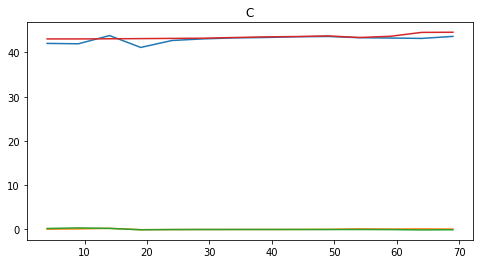

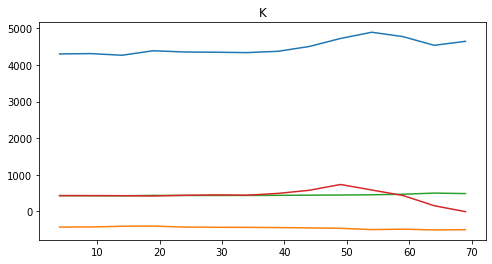

In [107]:
plt.figure(figsize=(8,4))
plt.title("C")
plt.plot(Fs, Cs[:, 0, 0])
plt.plot(Fs, Cs[:, 0, 1])
plt.plot(Fs, Cs[:, 1, 0])
plt.plot(Fs, Cs[:, 1, 1])
plt.show()


plt.figure(figsize=(8,4))
plt.title("K")
plt.plot(Fs, Ks[:, 0, 0])
plt.plot(Fs, Ks[:, 0, 1])
plt.plot(Fs, Ks[:, 1, 0])
plt.plot(Fs, Ks[:, 1, 1])
plt.show()

# EIV Estimator

In [142]:
def to_frequency_domain(df):
    data={}
    
    dt = (df["t"] - df["t"].shift()).median()
    for col in ["x", "y", "fy", "fx"]:
        data[col + "f"] = fftshift(fft(df[col].values))
    data["freqs"] = fftshift(fftfreq(data["xf"].shape[0], d = dt))
    return pd.DataFrame(data)

def eiv_estimate(df, freq):
    
    df_freq = pd.DataFrame()
    
    for (episode, axis), group in df.groupby(["episode", "axis"]):
        _df = to_frequency_domain(group)
        _df["axis"] = axis
        _df["episode"] = episode
        
        df_freq = pd.concat([df_freq, _df])
        
    df_freq = select_frequency(df_freq, freq=freq)
    
    Us = []
    Ys = []
    for episode, group in df_freq.groupby("episode"):
        U = group[["xf", "yf"]].values.transpose()
        Y = group[["fxf", "fyf"]].values.transpose()
        Us.append(U)
        Ys.append(Y)
        
    Us = np.array(Us)
    Ys = np.array(Ys)
    
    G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us, axis=0))
    C = np.imag(G) / (2 * np.pi * freq)
    K = np.real(G) + (2 * np.pi * freq) ** 2 * np.array([[1, 0], [0, 1]])

    return {"freq": freq,
            "G": G,
            "C": C,
            "K": K}
    return df_freq

def select_frequency(df, freq, tol=1e-2):
    
    return df[np.abs(df.freqs - freq) <= tol]


In [146]:
freq = 19
sel_df = df[(df.seal == True) & (df.freq == freq)]
with_seal = eiv_estimate(sel_df, freq)

In [145]:
sel_df = df[(df.seal == False) & (df.freq == freq)]
wo_seal = eiv_estimate(sel_df, freq)

In [148]:
print("Seal C",with_seal["C"] - wo_seal["C"])
print("Seal K", with_seal["K"] - wo_seal["K"])

Seal C [[ 4.31309214e+01 -4.16376767e-03]
 [-1.94106815e-03  4.31539045e+01]]
Seal K [[4307.78618542 -432.46533684]
 [ 431.82049547  425.42568115]]


In [149]:
Cs = []
Ks = []
Fs = []

for freq in df.freq.unique():
    
    sel_df = df[(df.seal == True) &  (df.freq == freq)]
    with_seal = eiv_estimate(sel_df, freq)
    
    sel_df = df[(df.seal == False) &  (df.freq == freq)]
    wo_seal = eiv_estimate(sel_df, freq)

    C = with_seal["C"] - wo_seal["C"]
    K = with_seal["K"] - wo_seal["K"]
    
    Cs.append(C)
    Ks.append(K)
    Fs.append(freq)
    
Cs = np.array(Cs)
Ks = np.array(Ks)
Fs = np.array(Fs)

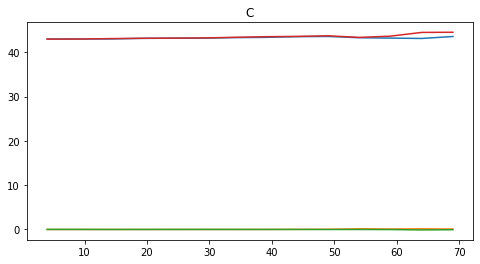

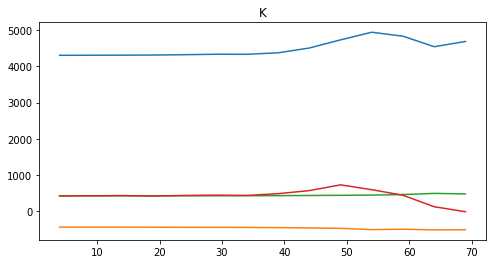

In [150]:
plt.figure(figsize=(8,4))
plt.title("C")
plt.plot(Fs, Cs[:, 0, 0])
plt.plot(Fs, Cs[:, 0, 1])
plt.plot(Fs, Cs[:, 1, 0])
plt.plot(Fs, Cs[:, 1, 1])
plt.show()


plt.figure(figsize=(8,4))
plt.title("K")
plt.plot(Fs, Ks[:, 0, 0])
plt.plot(Fs, Ks[:, 0, 1])
plt.plot(Fs, Ks[:, 1, 0])
plt.plot(Fs, Ks[:, 1, 1])
plt.show()